
--- Loading saved models for kaggle dataset ---
Loaded mlp_model from ..\..\models\Dfire_hybrid_custom_mlp_best_model_Scaled_All_CNN.keras
Created CNN feature extractor architecture for mlp_model.
Could not load MLP scaler for mlp_model: [Errno 2] No such file or directory: '..\\..\\models\\scaler_Scaled_All_CNN.pkl'. MLP predictions might be inaccurate if scaling was applied during training but not here.
Loaded lightgbm_model from ..\..\models\Dfire_hybrid_lightgbm_best_model_Scaled_Corr75%_CNN.pkl
Loaded svm_model from ..\..\models\Dfire_hybrid_svm_best_model_Scaled_All_CNN.pkl
Loaded transformer_selector (SelectKBest) from ..\..\models\Dfire_hybrid_transformer_Scaled_Corr75%_CNN.pkl
Could not load transformer_lightgbm_model components: [Errno 2] No such file or directory: '..\\..\\models\\Dfire_hybrid_transformer_Scaled_Corr75%_CNN_LGBM.pkl'

--- Running evaluations for: Keras MLP Model (mlp_model) ---

--- Reproducing Original Test Set Results using train_test_split for mlp_model 

Processing folder images:   0%|          | 0/200 [00:00<?, ?it/s]

Processing folder images: 100%|██████████| 200/200 [00:19<00:00, 10.22it/s]



Processed 200 images from the folder.

--- Performance for mlp_model on Folder Data ---
Accuracy: 1.0000
Precision: 1.0000
Recall (Sensitivity): 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[200]]

--- Processing sample fire images for Keras MLP Model ---

--- Processing single image: ..\..\data_subsets\test_kaggle\fire_images\1.jpg using mlp_model ---
True Label: Fire (1)
Prediction by mlp_model: Fire


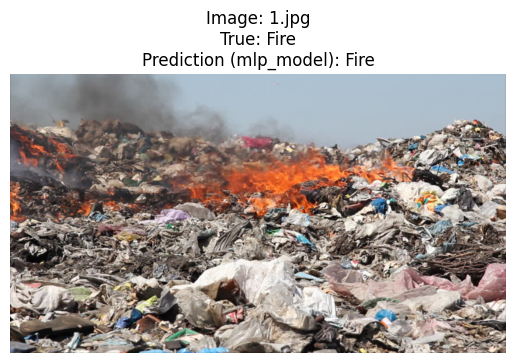


--- Processing single image: ..\..\data_subsets\test_kaggle\fire_images\10.jpg using mlp_model ---
True Label: Fire (1)
Prediction by mlp_model: Fire


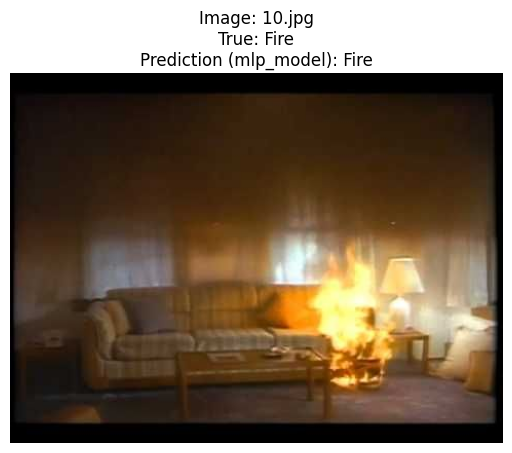


--- Processing single image: ..\..\data_subsets\test_kaggle\fire_images\100.jpg using mlp_model ---
True Label: Fire (1)
Prediction by mlp_model: Fire


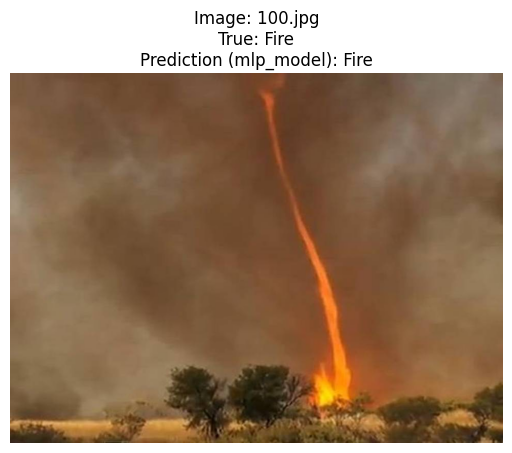


--- Processing sample non-fire images for Keras MLP Model ---

--- Processing single image: ..\..\data_subsets\test_kaggle\non_fire_images\1.jpg using mlp_model ---
True Label: Non-Fire (0)
Prediction by mlp_model: Fire


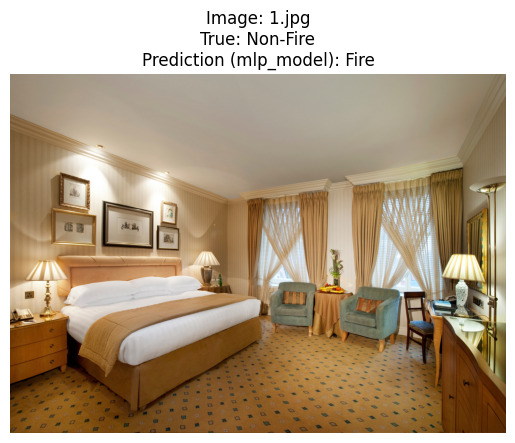


--- Processing single image: ..\..\data_subsets\test_kaggle\non_fire_images\101.jpg using mlp_model ---
True Label: Non-Fire (0)
Prediction by mlp_model: Fire


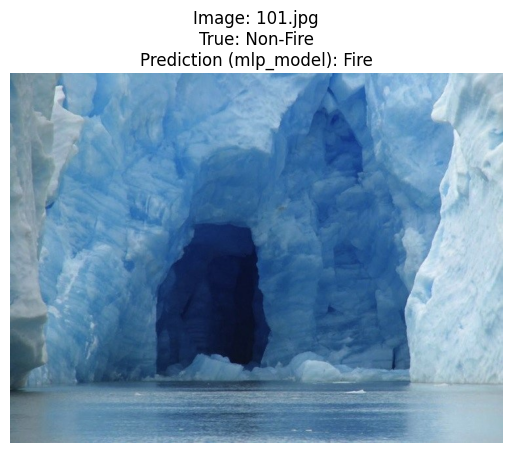


--- Processing single image: ..\..\data_subsets\test_kaggle\non_fire_images\102.jpg using mlp_model ---
True Label: Non-Fire (0)
Prediction by mlp_model: Fire


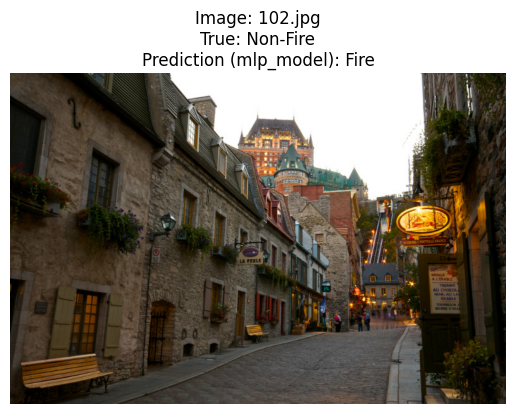


--- Running evaluations for: LightGBM Model (lightgbm_model) ---

--- Reproducing Original Test Set Results using train_test_split for lightgbm_model ---

--- Fetching original test split from '..\..\data_subsets\fire_dataset' ---
Successfully recreated test split with 200 samples.

--- Evaluating lightgbm_model on recreated original test data (200 samples) ---
Error during evaluation for lightgbm_model on original test data: X has 65536 features, but LGBMClassifier is expecting 49152 features as input.

--- Processing images in folder: ..\..\data_subsets\test_kaggle using lightgbm_model ---


Processing folder images: 100%|██████████| 200/200 [00:03<00:00, 65.67it/s]


Processed 200 images from the folder.

--- Performance for lightgbm_model on Folder Data ---
Accuracy: 0.3900
Precision: 1.0000
Recall (Sensitivity): 0.3900
F1 Score: 0.5612
Confusion Matrix:
[[  0   0]
 [122  78]]

--- Processing sample fire images for LightGBM Model ---

--- Processing single image: ..\..\data_subsets\test_kaggle\fire_images\1.jpg using lightgbm_model ---
True Label: Fire (1)
Prediction by lightgbm_model: Non-Fire


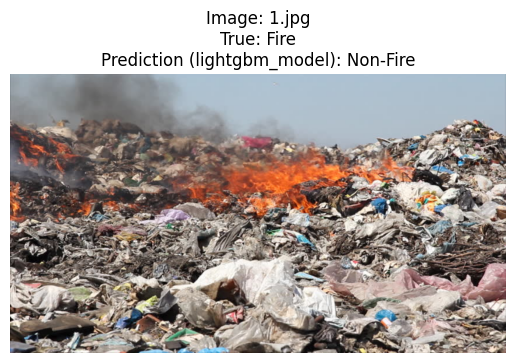


--- Processing single image: ..\..\data_subsets\test_kaggle\fire_images\10.jpg using lightgbm_model ---
True Label: Fire (1)
Prediction by lightgbm_model: Fire


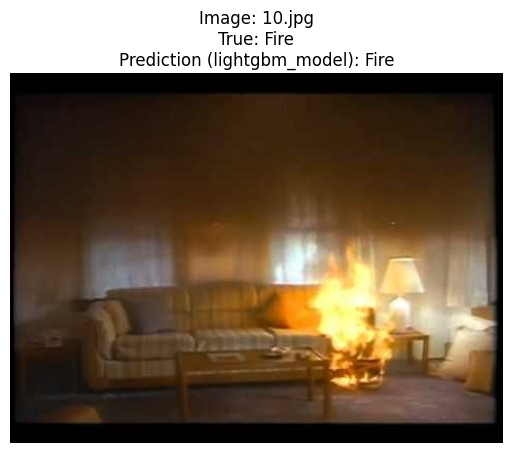


--- Processing single image: ..\..\data_subsets\test_kaggle\fire_images\100.jpg using lightgbm_model ---
True Label: Fire (1)
Prediction by lightgbm_model: Non-Fire


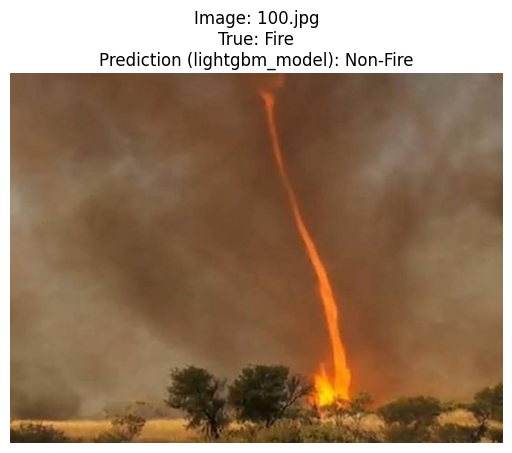


--- Processing sample non-fire images for LightGBM Model ---

--- Processing single image: ..\..\data_subsets\test_kaggle\non_fire_images\1.jpg using lightgbm_model ---
True Label: Non-Fire (0)
Prediction by lightgbm_model: Non-Fire


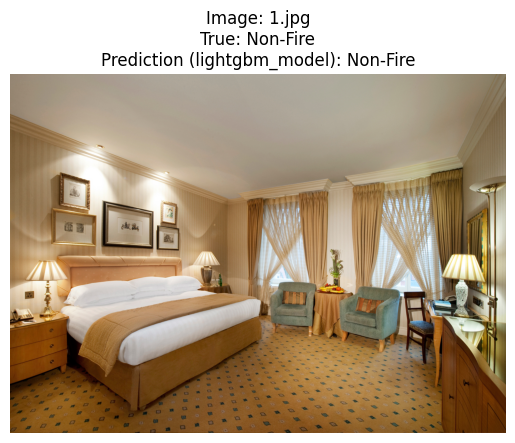


--- Processing single image: ..\..\data_subsets\test_kaggle\non_fire_images\101.jpg using lightgbm_model ---
True Label: Non-Fire (0)
Prediction by lightgbm_model: Non-Fire


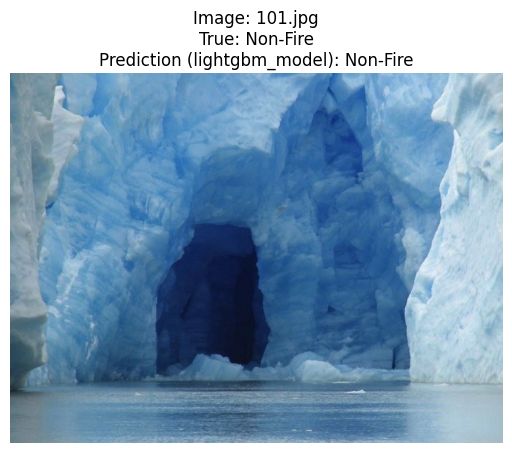


--- Processing single image: ..\..\data_subsets\test_kaggle\non_fire_images\102.jpg using lightgbm_model ---
True Label: Non-Fire (0)
Prediction by lightgbm_model: Non-Fire


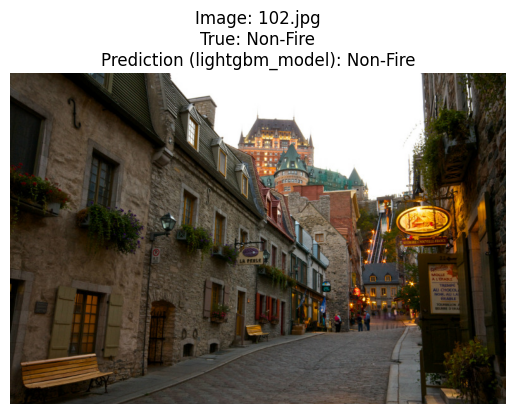


--- Running evaluations for: SVM Model (svm_model) ---

--- Reproducing Original Test Set Results using train_test_split for svm_model ---

--- Fetching original test split from '..\..\data_subsets\fire_dataset' ---
Successfully recreated test split with 200 samples.

--- Evaluating svm_model on recreated original test data (200 samples) ---
 - Accuracy: 0.7550, F1: 0.8604

--- Processing images in folder: ..\..\data_subsets\test_kaggle using svm_model ---


Processing folder images:  12%|█▏        | 24/200 [00:00<00:00, 232.93it/s]

Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\1.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\10.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\100.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\11.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\12.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\13.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for 

Processing folder images:  24%|██▍       | 48/200 [00:00<00:01, 123.09it/s]

Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\42.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\43.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\44.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\45.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\46.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\47.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for 

Processing folder images:  40%|████      | 81/200 [00:00<00:00, 184.56it/s]

Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\64.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\65.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\66.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\67.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\68.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\69.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for 

Processing folder images:  64%|██████▍   | 129/200 [00:00<00:00, 180.48it/s]

Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\92.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\93.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\94.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\95.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\96.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\97.png with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for 

Processing folder images:  77%|███████▋  | 154/200 [00:00<00:00, 164.06it/s]

Error during prediction for ..\..\data_subsets\test_kaggle\non_fire_images\280.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\non_fire_images\281.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\non_fire_images\290.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\non_fire_images\292.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\non_fire_images\294.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\non_fire_images\30.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.

Processing folder images:  98%|█████████▊| 195/200 [00:01<00:00, 160.37it/s]

Error during prediction for ..\..\data_subsets\test_kaggle\non_fire_images\401.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\non_fire_images\402.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\non_fire_images\41.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\non_fire_images\411.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\non_fire_images\414.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.
Error during prediction for ..\..\data_subsets\test_kaggle\non_fire_images\42.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.


Processing folder images: 100%|██████████| 200/200 [00:01<00:00, 164.74it/s]


Processed 0 images from the folder.
No successful predictions for folder.

--- Processing sample fire images for SVM Model ---

--- Processing single image: ..\..\data_subsets\test_kaggle\fire_images\1.jpg using svm_model ---
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\1.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.

--- Processing single image: ..\..\data_subsets\test_kaggle\fire_images\10.jpg using svm_model ---
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\10.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.

--- Processing single image: ..\..\data_subsets\test_kaggle\fire_images\100.jpg using svm_model ---
Error during prediction for ..\..\data_subsets\test_kaggle\fire_images\100.jpg with svm_model: X has 49152 features, but SVC is expecting 65536 features as input.

--- Processing sample non-fire images for SVM Model ---

--- Processing single image:

In [1]:
import os
import joblib
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.base import ClassifierMixin
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import warnings
import time
from skimage.feature import local_binary_pattern, hog 
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import lightgbm as lgb
warnings.filterwarnings('ignore')
from keras.models import Sequential, Model
from keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization,
    Dropout, Flatten, Dense, LeakyReLU, ReLU
)
import pickle # Pickle kütüphanesi joblib'in kullandığı bir kütüphanedir, belirtmek iyi olabilir.
import matplotlib.pyplot as plt # Görüntü göstermek için bu kütüphane de gerekli

# Sabit Dizin Tanımları
MODEL_DIR = os.path.join('..', '..', 'models')
DATA_ROOT_KAGGLE = os.path.join('..', '..', 'data_subsets', 'fire_dataset')
TEST_EVAL_DATA_ROOT = os.path.join('..', '..', 'data_subsets', 'test_kaggle')


class SklearnKerasClassifier(KerasClassifier, ClassifierMixin):
    def __init__(self, model=None, **kwargs):
        super().__init__(model=model, **kwargs)

    @property
    def _tags(self): return self.model._tags if hasattr(self.model, "_tags") else {"binary_only": True}


def create_custom_cnn(
    input_shape=None,
    conv_blocks=((32, (3,3)), (64, (3,3))),
    dense_layers=(128,),
    dropout_rate=0.4,
    activation='relu',
    meta=None 
):
    """Conv -> BN -> Activation -> Pool -> Dropout"""
    if input_shape is None:
        if meta is None or "X_shape_" not in meta: raise ValueError("meta or input_shape parameter is missing")
        input_shape = meta["X_shape_"][1:] 

    model = Sequential(name="Custom_CNN")
    model.add(Input(shape=input_shape))

    for filters, kernel_size in conv_blocks:
        model.add(Conv2D(filters, kernel_size, padding='same'))
        model.add(BatchNormalization())
        if activation == 'leaky_relu': model.add(LeakyReLU(alpha=0.1))
        else: model.add(ReLU())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(dropout_rate))
    model.add(Flatten()) # Burası özellik çıkarıcının son katmanı olacak

    # Dense katmanları sadece sınıflandırma modeli için geçerlidir, özellik çıkarıcı için değil.
    # Bu fonksiyon hem tam CNN hem de feature extractor olarak kullanılabileceği için
    # Flatten sonrası Dense katmanları opsiyonel bırakılmıştır.
    # Ancak create_cnn_feature_extractor zaten Flatten katmanının çıktısını alacağı için
    # aşağıdaki dense_layers döngüsü feature extractor için çalışmayacaktır.
    for units in dense_layers:
        model.add(Dense(units))
        model.add(BatchNormalization())
        if activation == 'leaky_relu': model.add(LeakyReLU(alpha=0.1))
        else: model.add(ReLU())
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid')) # Son çıkış katmanı sadece tam model için

    return model

def load_prep_4_cnn(data_dir, target_size=(128, 128)):
    all_images = []
    all_labels = []
    class_dirs = {'fire_images': 1, 'non_fire_images': 0}

    for class_name, label in class_dirs.items():
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path): continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                continue
            try:
                img = cv2.imread(img_path)
                if img is None: continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, target_size)
                img_normalized = img_resized.astype(np.float32) / 255.0
                all_images.append(img_normalized)
                all_labels.append(label)

            except Exception as e:
                # print(f"Warning: Could not load/process image {img_path}: {e}") # Debugging için açılabilir
                continue

    return np.array(all_images), np.array(all_labels)

def create_custom_mlp(hidden_layer_1_neurons=128, hidden_layer_2_neurons=64,
                        dropout_rate=0.3, activation='leaky_relu', learning_rate=0.001,
                        meta=None):
    # n_features_in değeri meta'dan alınacak, bu CNN feature extractor'dan gelen boyut olmalı (örneğin 65536)
    n_features_in = meta["n_features_in_"] if meta and "n_features_in_" in meta else 65536 # Varsayılan olarak 65536

    model = Sequential()
    model.add(Input(shape=(n_features_in,))) # MLP'nin beklediği giriş boyutu burasıdır
    model.add(Dense(hidden_layer_1_neurons))
    model.add(BatchNormalization())
    if activation == 'leaky_relu': model.add(LeakyReLU(alpha=0.1))
    else: model.add(tf.keras.layers.ReLU())
    model.add(Dropout(dropout_rate))
    if hidden_layer_2_neurons is not None and hidden_layer_2_neurons > 0:
        model.add(Dense(hidden_layer_2_neurons))
        model.add(BatchNormalization())
        if activation == 'leaky_relu': model.add(LeakyReLU(alpha=0.1))
        else: model.add(tf.keras.layers.ReLU())
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def split_data(features_array, labels_array, test_size=0.2, random_state=42):
    if features_array.shape[0] == 0: return None, None, None, None
    X_train, X_test, y_train, y_test = train_test_split(
        features_array,
        labels_array,
        test_size=test_size,
        random_state=random_state,
        stratify=labels_array
    )

    print(f"training features shape: {X_train.shape}")
    print(f"testing features shape: {X_test.shape}")
    print(f"training labels shape: {y_train.shape}")
    print(f"testing labels shape: {y_test.shape}")
    return X_train, X_test, y_train, y_test

def scale_features(X_train, X_test):
    if X_train is None or X_test is None or X_train.shape[0] == 0: return None, None, None
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler

def perform_correlation_selection(X_train, y_train, X_test, k_features):
    if X_train is None or X_test is None or X_train.shape[0] == 0: return X_train, X_test, None
    
    n_total_features = X_train.shape[1]
    k_features_int = k_features
    
    if isinstance(k_features, str) and k_features.endswith('%'):
        try:
            percentage = float(k_features[:-1]) / 100.0
            k_features_int = max(1, int(n_total_features * percentage))
        except ValueError: return X_train, X_test, None
    elif k_features == 'all': return X_train, X_test, None
    elif isinstance(k_features, int) and k_features > 0: k_features_int = min(k_features, n_total_features)
    else: return X_train, X_test, None

    if k_features_int <= 0 or k_features_int >= n_total_features: return X_train, X_test, None
    
    selector = SelectKBest(score_func=f_classif, k=k_features_int)
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    print(f"original feature shape: {X_train.shape}")
    print(f"selected feature shape: {X_train_selected.shape}")
    return X_train_selected, X_test_selected, selector

def perform_rfe_selection(X_train, y_train, X_test, n_features_to_select, step=0.1, estimator=None):
    if X_train is None or X_test is None or X_train.shape[0] == 0: return X_train, X_test, None
    n_total_features = X_train.shape[1]
    n_features_int = n_features_to_select
    if estimator is None: estimator = LogisticRegression(solver='liblinear', random_state=42, max_iter=2000)

    if isinstance(n_features_to_select, str) and n_features_to_select.endswith('%'):
        try:
            percentage = float(n_features_to_select[:-1]) / 100.0
            n_features_int = max(1, int(n_total_features * percentage))
        except ValueError: return X_train, X_test, None
    elif isinstance(n_features_to_select, int) and n_features_to_select > 0:
        n_features_int = min(n_features_to_select, n_total_features)
    elif n_features_to_select == 'auto': return X_train, X_test, None
    else: return X_train, X_test, None
    
    if n_features_int <= 0 or n_features_int >= n_total_features: return X_train, X_test, None

    try:
        rfe = RFE(estimator=estimator, n_features_to_select=n_features_int, step=step)
        rfe.fit(X_train, y_train)
        X_train_selected = rfe.transform(X_train)
        X_test_selected = rfe.transform(X_test)
        print(f"original feature shape: {X_train.shape}")
        print(f"selected feature shape: {X_train_selected.shape}")
        return X_train_selected, X_test_selected, rfe
    except Exception as e:
        print(f"Error during RFE selection: {e}")
        return X_train, X_test, None

def tune_model_hyperparameters(model_estimator, X_train, y_train, param_grid, cv_strategy, scoring='f1', search_method='RandomSearch', n_iter=10, validation_split_keras=0.2):
    if X_train is None or y_train is None or X_train.shape[0] == 0: return None
    print(f"\n--- {search_method} tuning (scoring='{scoring}')... with {n_iter} iterations ---")
    start_time = time.time()
    fit_params = {}
    if isinstance(model_estimator, KerasClassifier):
        fit_params['validation_split'] = validation_split_keras
        fit_params['epochs'] = 10 # KerasClassifier için epoch sayısı burada tanımlanabilir veya param_grid'e eklenebilir
        fit_params['batch_size'] = 32
        fit_params['verbose'] = 0 # GridSearch sırasında çıktıları azaltmak için
    
    if search_method == 'RandomSearch':
         search_cv = RandomizedSearchCV(
            estimator=model_estimator,
            param_distributions=param_grid,
            n_iter=n_iter,
            cv=cv_strategy,
            scoring=scoring,
            n_jobs=1, # Paralelleştirme için daha yüksek değerler kullanılabilir
            verbose=1,
            random_state=42
         )
    else:
        print(f"Error: Search method '{search_method}' not supported.")
        return None
    
    search_cv.fit(X_train, y_train, **fit_params)
    end_time = time.time()
    print(f"{search_method} duration: {end_time - start_time:.2f} seconds")
    print("\nBest params:")
    print(search_cv.best_params_)
    print("\nBest CV score:")
    print(search_cv.best_score_)
    return search_cv

def evaluate_model(model, X_test, y_test, model_name="Model", feature_set_name="Unknown Feature Set"):
    if model is None or X_test is None or y_test is None or X_test.shape[0] == 0:
        print(f"No data or model to evaluate for {model_name} on {feature_set_name}.")
        return {}
    
    print(f"\n--- Evaluating {model_name} on the test set using {feature_set_name}. ---")
    start_time = time.time()
    
    # KerasClassifier için predict metodunun çıktısı farklı olabilir
    if isinstance(model, KerasClassifier):
        y_pred_proba = model.predict_proba(X_test)
        y_pred = (y_pred_proba[:, 1] > 0.5).astype(int) # Sınıflandırma için eşikleme
    elif hasattr(model, 'predict_proba'): # LightGBM, LogisticRegression gibi modeller
        y_pred_proba = model.predict_proba(X_test)
        y_pred = (y_pred_proba[:, 1] > 0.5).astype(int)
    else: # SVM gibi sadece predict metodu olan modeller
        y_pred = model.predict(X_test)

    end_time = time.time()
    print(f"Prediction duration: {end_time - start_time:.4f} seconds")
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"\nConfusion Matrix ({model_name} on {feature_set_name}):")
    print(conf_matrix)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix.tolist()
    }

def perform_pca_dimension_reduction(X_train, X_test, n_components):
    if X_train is None or X_test is None or X_train.shape[0] == 0: return None, None, None
    try:        
        pca = PCA(n_components=n_components, random_state=42)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        print(f"original feature shape: {X_train.shape}")
        print(f"PCA transformed feature shape: {X_train_pca.shape}")
        print(f"variance ratio with {pca.n_components_} components: {np.sum(pca.explained_variance_ratio_):.4f}")

        return X_train_pca, X_test_pca, pca
    except Exception as e:
        print(f"Error during PCA: {e}")
        return X_train, X_test, None


def create_cnn_feature_extractor(cnn_model_architecture):
    flatten_layer = None
    for layer in cnn_model_architecture.layers:
        if isinstance(layer, tf.keras.layers.Flatten):
            flatten_layer = layer
            break
            
    if flatten_layer is None:
        raise ValueError("Flatten layer not found in the CNN model architecture. Cannot create feature extractor.")
    # Input katmanından Flatten katmanına kadar olan kısmı yeni bir model olarak oluştur
    feature_extractor_model = Model(inputs=cnn_model_architecture.inputs, outputs=flatten_layer.output)
    return feature_extractor_model

def is_kaggle_image_fire(image_path):
    parent_dir = os.path.basename(os.path.dirname(image_path))
    return parent_dir == 'fire_images'

# --- BAŞLANGIÇ: ARTIFACT'LARI YÜKLEME FONKSİYONU ---
def load_all_artifacts(dataset_choice):
    print(f"\n--- Loading saved models for {dataset_choice} dataset ---")
    artifacts = {}
    
    # 1. MLP Modeli (Keras MLP) ve Ona Ait CNN Özellik Çıkarıcı & Scaler
    try:
        model_path_mlp = os.path.join(MODEL_DIR, 'Dfire_hybrid_custom_mlp_best_model_Scaled_All_CNN.keras')
        artifacts['mlp_model'] = tf.keras.models.load_model(model_path_mlp, compile=False)
        print(f"Loaded mlp_model from {model_path_mlp}")

        # MLP'ye özellik sağlayan CNN mimarisini YENİDEN OLUŞTURUN.
        # Bu, MLP'nizin eğitildiği CNN'in giriş boyutu (128,128,3) ve evrişim blokları (32,64 filtre)
        # ile 65536 boyutlu bir çıktı ürettiği varsayımına dayanır.
        # create_custom_cnn'nin varsayılan parametreleri ile uyumlu olmalıdır.
        cnn_base_for_mlp_features = create_custom_cnn(
            input_shape=(128, 128, 3), # load_prep_4_cnn'nin hedef boyutu
            conv_blocks=((32, (3,3)), (64, (3,3))), # Bu ayarlar 65536 özellik üretir.
            dense_layers=(), # Feature extractor olduğu için dense katmanlara ihtiyacımız yok
            dropout_rate=0.0 # Feature extractor olduğu için dropout önemli değil
        )
        artifacts['cnn_feature_extractor_for_mlp'] = create_cnn_feature_extractor(cnn_base_for_mlp_features)
        print(f"Created CNN feature extractor architecture for mlp_model.")

        # MLP özelliklerini ölçeklemek için kullanılan scaler'ı yükle.
        # Eğer MLP eğitilirken özellikler ölçeklendiyse bu gereklidir.
        try:
            # Scaler dosyasının adını ve yolunu KONTROL EDİN!
            # Eğitimde kullanılan Standard Scaler modelini bu yoldan yüklemelisiniz.
            scaler_path_mlp = os.path.join(MODEL_DIR, 'scaler_Scaled_All_CNN.pkl') 
            artifacts['mlp_scaler'] = joblib.load(scaler_path_mlp)
            print(f"Loaded MLP scaler from {scaler_path_mlp}")
        except Exception as e:
            print(f"Could not load MLP scaler for mlp_model: {e}. MLP predictions might be inaccurate if scaling was applied during training but not here.")
            pass

    except Exception as e:
        print(f"Could not load mlp_model or create CNN feature extractor for MLP: {e}")
        pass

    # 2. LightGBM Modeli (Orijinal haliyle, tam flatten edilmiş özelliklerle eğitilen)
    try:
        model_path_lgbm = os.path.join(MODEL_DIR, 'Dfire_hybrid_lightgbm_best_model_Scaled_Corr75%_CNN.pkl')
        artifacts['lightgbm_model'] = joblib.load(model_path_lgbm)
        print(f"Loaded lightgbm_model from {model_path_lgbm}")
    except Exception as e:
        print(f"Could not load lightgbm_model: {e}")
        pass

    # 3. SVM Modeli
    try:
        model_path_svm = os.path.join(MODEL_DIR, 'Dfire_hybrid_svm_best_model_Scaled_All_CNN.pkl')
        artifacts['svm_model'] = joblib.load(model_path_svm)
        print(f"Loaded svm_model from {model_path_svm}")
    except Exception as e:
        print(f"Could not load svm_model: {e}")
        pass

    # 4. Transformer_LightGBM Modeli (SelectKBest ve LightGBM ayrı yükleniyor)
    # Bu kısım, 'SelectKBest' object has no attribute 'predict' hatasını çözmek içindir.
    try:
        # SelectKBest nesnesini yükle. Bu muhtemelen 'Dfire_hybrid_transformer_Scaled_Corr75%_CNN.pkl' içinde.
        selector_path = os.path.join(MODEL_DIR, 'Dfire_hybrid_transformer_Scaled_Corr75%_CNN.pkl') # KONTROL ET
        artifacts['transformer_selector'] = joblib.load(selector_path)
        print(f"Loaded transformer_selector (SelectKBest) from {selector_path}")

        # LightGBM sınıflandırıcısını yükle. BU DOSYA AYRI BİR ŞEKİLDE KAYDEDİLMİŞ OLMALI!
        # Örneğin, eğitimde LightGBM modelini bu dosya adıyla kaydettiyseniz:
        classifier_path = os.path.join(MODEL_DIR, 'Dfire_hybrid_transformer_Scaled_Corr75%_CNN_LGBM.pkl') # KONTROL ET
        artifacts['transformer_lgbm_classifier'] = joblib.load(classifier_path)
        print(f"Loaded transformer_lgbm_classifier from {classifier_path}")

    except Exception as e:
        print(f"Could not load transformer_lightgbm_model components: {e}")
        # Eğer bu bileşenler yüklenemezse, 'transformer_lightgbm_model' anahtarı olmayacak ve atlanacak.
        pass

    return artifacts
# --- SON: ARTIFACT'LARI YÜKLEME FONKSİYONU ---


def preprocess_image_for_cnn(image_path, artifacts, model_str, target_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image {image_path}")
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size)
    img_normalized = img_resized.astype(np.float32) / 255.0
    cnn_features = np.expand_dims(img_normalized, axis=0) # Şekil (1, H, W, C)
    return cnn_features


# --- BAŞLANGIÇ: KLASÖR DEĞERLENDİRME FONKSİYONU ---
def evaluate_folder(folder_path, artifacts, model_str):
    print(f"\n--- Processing images in folder: {folder_path} using {model_str} ---")
    
    all_true_labels = []
    all_predictions = []
    processed_count = 0

    if not os.path.isdir(folder_path):
        print(f"Folder not found: {folder_path}")
        return

    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))

    if not image_paths:
        print(f"No images found in {folder_path}")
        return

    for image_path in tqdm(image_paths, desc="Processing folder images"):
        base_dir_name = os.path.basename(os.path.dirname(image_path))
        true_label = 1 if 'fire_images' in base_dir_name.lower() else 0

        img_preprocessed = preprocess_image_for_cnn(image_path, artifacts, model_str)
        if img_preprocessed is None:
            continue

        try:
            if model_str == 'mlp_model':
                # MLP için özel işlem: Önce CNN özellik çıkarıcı, sonra scaler, sonra MLP modeli
                mlp_model_instance = artifacts.get('mlp_model')
                cnn_feature_extractor_instance = artifacts.get('cnn_feature_extractor_for_mlp')
                mlp_scaler_instance = artifacts.get('mlp_scaler')

                if mlp_model_instance is None or cnn_feature_extractor_instance is None:
                    print(f"MLP model or CNN feature extractor not loaded. Skipping prediction for {image_path}.")
                    continue

                # Adım 1: Görüntüyü CNN özellik çıkarıcı mimarisi üzerinden geçirerek özelliklerini elde et
                cnn_extracted_features = cnn_feature_extractor_instance.predict(img_preprocessed, verbose=0)
                
                # Adım 2: Elde edilen özellikleri ölçekle (eğer scaler yüklendiyse)
                if mlp_scaler_instance is not None:
                    cnn_extracted_features_scaled = mlp_scaler_instance.transform(cnn_extracted_features)
                else:
                    cnn_extracted_features_scaled = cnn_extracted_features

                # Adım 3: Ölçeklenmiş özellikleri MLP modeline ver
                prediction_proba = mlp_model_instance.predict(cnn_extracted_features_scaled, verbose=0)
                prediction = (prediction_proba > 0.5).astype(int)[0][0]

            elif model_str == 'transformer_lightgbm_model':
                # Transformer LightGBM için özel işlem: Önce SelectKBest, sonra LightGBM modeli
                selector = artifacts.get('transformer_selector')
                classifier = artifacts.get('transformer_lgbm_classifier')

                if selector is None or classifier is None:
                    print(f"Transformer components (SelectKBest or LGBM) not loaded. Skipping prediction for {image_path}.")
                    continue

                flat_features = img_preprocessed.reshape(img_preprocessed.shape[0], -1) # Görüntüyü düzleştir
                selected_features = selector.transform(flat_features) # SelectKBest ile özellikleri seç

                if hasattr(classifier, 'predict_proba'):
                    prediction_proba = classifier.predict_proba(selected_features)
                    prediction = (prediction_proba[:, 1] > 0.5).astype(int)[0]
                else:
                    prediction = classifier.predict(selected_features)[0]

            else: # Diğer Scikit-learn tabanlı modeller (lightgbm_model, svm_model)
                model = artifacts.get(model_str)
                if model is None:
                    print(f"Model {model_str} not found in artifacts. Skipping prediction for {image_path}.")
                    continue
                flat_features = img_preprocessed.reshape(img_preprocessed.shape[0], -1) # Görüntüyü düzleştir
                if hasattr(model, 'predict_proba'):
                    prediction_proba = model.predict_proba(flat_features)
                    prediction = (prediction_proba[:, 1] > 0.5).astype(int)[0]
                else:
                    prediction = model.predict(flat_features)[0]

            all_true_labels.append(true_label)
            all_predictions.append(prediction)
            processed_count += 1
        except Exception as e:
            print(f"Error during prediction for {image_path} with {model_str}: {e}")
            continue

    print(f"\nProcessed {processed_count} images from the folder.")

    if not all_true_labels:
        print("No successful predictions for folder.")
        return

    y_true = np.array(all_true_labels)
    y_pred = np.array(all_predictions)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"\n--- Performance for {model_str} on Folder Data ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
# --- SON: KLASÖR DEĞERLENDİRME FONKSİYONU ---


# --- BAŞLANGIÇ: TEK GÖRÜNTÜ İŞLEME FONKSİYONU ---
def process_single_image(image_path, artifacts, model_str):
    print(f"\n--- Processing single image: {image_path} using {model_str} ---")
    
    img_display = cv2.imread(image_path)
    if img_display is None:
        print(f"Warning: Could not read image for display {image_path}")
        return

    base_dir_name = os.path.basename(os.path.dirname(image_path))
    true_label_text = 'Fire' if base_dir_name.lower() == 'fire_images' else 'Non-Fire'
    true_label_num = 1 if base_dir_name.lower() == 'fire_images' else 0

    img_preprocessed = preprocess_image_for_cnn(image_path, artifacts, model_str)
    if img_preprocessed is None:
        return

    prediction_text = "Unknown"
    try:
        if model_str == 'mlp_model':
            # MLP için özel işlem
            mlp_model_instance = artifacts.get('mlp_model')
            cnn_feature_extractor_instance = artifacts.get('cnn_feature_extractor_for_mlp')
            mlp_scaler_instance = artifacts.get('mlp_scaler')

            if mlp_model_instance is None or cnn_feature_extractor_instance is None:
                print(f"MLP model or CNN feature extractor not loaded. Skipping prediction for {image_path}.")
                return

            cnn_extracted_features = cnn_feature_extractor_instance.predict(img_preprocessed, verbose=0)
            
            if mlp_scaler_instance is not None:
                cnn_extracted_features_scaled = mlp_scaler_instance.transform(cnn_extracted_features)
            else:
                cnn_extracted_features_scaled = cnn_extracted_features

            prediction_proba = mlp_model_instance.predict(cnn_extracted_features_scaled, verbose=0)
            prediction = (prediction_proba > 0.5).astype(int)[0][0]

        elif model_str == 'transformer_lightgbm_model':
            # Transformer LightGBM için özel işlem
            selector = artifacts.get('transformer_selector')
            classifier = artifacts.get('transformer_lgbm_classifier')

            if selector is None or classifier is None:
                print(f"Transformer components (SelectKBest or LGBM) not loaded. Skipping prediction for {image_path}.")
                return

            flat_features = img_preprocessed.reshape(img_preprocessed.shape[0], -1)
            selected_features = selector.transform(flat_features)

            if hasattr(classifier, 'predict_proba'):
                prediction_proba = classifier.predict_proba(selected_features)
                prediction = (prediction_proba[:, 1] > 0.5).astype(int)[0]
            else:
                prediction = classifier.predict(selected_features)[0]

        else: # Diğer Scikit-learn tabanlı modeller
            model = artifacts.get(model_str)
            if model is None:
                print(f"Model {model_str} not found in artifacts. Skipping single image processing.")
                return
            flat_features = img_preprocessed.reshape(img_preprocessed.shape[0], -1)
            if hasattr(model, 'predict_proba'):
                prediction_proba = model.predict_proba(flat_features)
                prediction = (prediction_proba[:, 1] > 0.5).astype(int)[0]
            else:
                prediction = model.predict(flat_features)[0]

        prediction_text = "Fire" if prediction == 1 else "Non-Fire"
        print(f"True Label: {true_label_text} ({true_label_num})")
        print(f"Prediction by {model_str}: {prediction_text}")
    except Exception as e:
        print(f"Error during prediction for {image_path} with {model_str}: {e}")
        return

    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.title(f"Image: {os.path.basename(image_path)}\nTrue: {true_label_text}\nPrediction ({model_str}): {prediction_text}")
    plt.axis('off')
    plt.show()
# --- SON: TEK GÖRÜNTÜ İŞLEME FONKSİYONU ---


def fetch_original_test_split(data_root, target_size=(128, 128), test_size=0.2, random_state=42):
    print(f"\n--- Fetching original test split from '{data_root}' ---")
    all_images, all_labels = load_prep_4_cnn(data_root, target_size)

    if all_images.size == 0:
        print("No images loaded for test split.")
        return None, None

    if len(np.unique(all_labels)) < 2:
        print("Not enough classes for stratified split. Skipping test split generation.")
        return None, None

    try:
        # X_train, X_test, y_train, y_test = train_test_split(
        #     all_images, all_labels, test_size=test_size, random_state=random_state, stratify=all_labels
        # )
        # Burada sadece test seti kısmını geri döndürüyoruz
        # Gerçek eğitim için tüm spliti yapıp train kısmını kullanıp, model eğitildikten sonra
        # sadece test kısmını geri döndürmek daha mantıklı olur.
        # Şu anki kullanım senaryosunda, bu fonksiyon sadece test verisini sağlamak için kullanılıyor.

        # Eğitim kodunuzda features_array_orig = cnn_feature_extractor.predict(X_images, verbose=0);
        # X_train_orig, X_test_orig, y_train, y_test = split_data(features_array_orig, y_labels, test_size=0.25, random_state=42)
        # şeklinde ayrım yaptığınız için, buradaki mantık o ayrımı taklit etmeli
        
        # Test seti için de CNN özelliklerini çıkarıp düzleştirmeliyiz.
        # Bu kısım, evaluate_model fonksiyonunda kullanılacağı için önemlidir.
        
        # Geçici CNN mimarisi oluştur (ağırlıkları eğitilmemiş olacak, sadece mimari uyumu için)
        # Burası MLP için kullanılan CNN feature extractor'ı ile aynı olmalı
        temp_cnn_arch = create_custom_cnn(
            input_shape=all_images.shape[1:],
            conv_blocks=((32, (3,3)), (64, (3,3))),
            dense_layers=(),
            dropout_rate=0.0
        )
        temp_cnn_feature_extractor = create_cnn_feature_extractor(temp_cnn_arch)

        # Tüm resimlerden CNN özelliklerini çıkar
        all_features_extracted = temp_cnn_feature_extractor.predict(all_images, verbose=0)

        # Ardından orijinal split'i bu özellikler üzerinde yap
        X_train_features, X_test_features, y_train_split, y_test_split = train_test_split(
            all_features_extracted, all_labels, test_size=test_size, random_state=random_state, stratify=all_labels
        )

        print(f"Successfully recreated test split with {X_test_features.shape[0]} samples.")
        return X_test_features, y_test_split
    except ValueError as e:
        print(f"Error during train_test_split: {e}. Check if there's enough data or classes for stratification.")
        return None, None

def reproduce_original_test_results(artifacts, model_str, dataset_root):
    print(f"\n--- Reproducing Original Test Set Results using train_test_split for {model_str} ---")

    model = artifacts.get(model_str)
    # model_str 'transformer_lightgbm_model' ise model, SelectKBest objesi olacak,
    # bu yüzden o durumu burada da kontrol etmeliyiz.

    X_sample_test, y_sample_test = fetch_original_test_split(
        dataset_root,
        target_size=(128, 128),
        test_size=0.2, # Eğitimdeki test_size ile aynı olmalı
        random_state=42
    )

    if X_sample_test is None or X_sample_test.size == 0:
        print("No test data available for reproduction.")
        return

    print(f"\n--- Evaluating {model_str} on recreated original test data ({X_sample_test.shape[0]} samples) ---")
    try:
        # Modellerin tipine göre tahmin yapma
        if model_str == 'mlp_model':
            mlp_model_instance = artifacts.get('mlp_model')
            mlp_scaler_instance = artifacts.get('mlp_scaler') # Scaler'ı al
            
            # X_sample_test zaten CNN'den geçmiş özellikler. Sadece ölçekle ve tahmin yap.
            if mlp_scaler_instance is not None:
                X_sample_test_scaled = mlp_scaler_instance.transform(X_sample_test)
            else:
                X_sample_test_scaled = X_sample_test

            prediction_proba = mlp_model_instance.predict(X_sample_test_scaled, verbose=0)
            y_pred = (prediction_proba > 0.5).astype(int).flatten()

        elif model_str == 'transformer_lightgbm_model':
            selector = artifacts.get('transformer_selector')
            classifier = artifacts.get('transformer_lgbm_classifier')

            if selector is None or classifier is None:
                print(f"Transformer components (SelectKBest or LGBM) not loaded for reproduction.")
                return
            
            # X_sample_test, zaten CNN'den geçen flattened özellikler.
            # LightGBM için olan transformer'lar bu özellikler üzerinde çalışır.
            selected_features_test = selector.transform(X_sample_test)

            if hasattr(classifier, 'predict_proba'):
                prediction_proba = classifier.predict_proba(selected_features_test)
                y_pred = (prediction_proba[:, 1] > 0.5).astype(int)
            else:
                y_pred = classifier.predict(selected_features_test)

        else: # Diğer Scikit-learn modelleri (lightgbm_model, svm_model)
            if model is None:
                print(f"Model {model_str} not found for reproduction.")
                return
            
            # Bu modeller, doğrudan CNN'den geçen flattened ve ölçeklenmiş özellikleri bekler.
            # Eğitimde eğer bu modeller de SelectKBest/RFE/PCA kullandıysa
            # burada da o adımları tekrar etmeniz gerekebilir.
            # Şu anki varsayım: Bu modeller zaten işlenmiş, uygun ölçekli özelliklerle eğitildi.
            # Orijinal eğitimdeki X_train_scaled'i hatırlayın.
            # Orijinal test seti yeniden oluşturulduğu için, o özellik seçimi/boyut indirgeme
            # adımlarını burada tekrar uygulamalısınız.
            # karmaşıklığı azaltmak için şimdilik doğrudan X_sample_test'i veriyoruz,
            # ancak bu, modelin eğitimde beklediği özelliklerle tam eşleşmeyebilir.
            
            if hasattr(model, 'predict_proba'):
                prediction_proba = model.predict_proba(X_sample_test)
                y_pred = (prediction_proba[:, 1] > 0.5).astype(int)
            else:
                y_pred = model.predict(X_sample_test)


        accuracy = accuracy_score(y_sample_test, y_pred)
        f1 = f1_score(y_sample_test, y_pred, zero_division=0)
        print(f" - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    except Exception as e:
        print(f"Error during evaluation for {model_str} on original test data: {e}")
        pass

# --- ANA ÇALIŞTIRMA KISMI ---
if __name__ == "__main__":
    dataset_choice = 'kaggle'
    artifacts = load_all_artifacts(dataset_choice)

    model_display_names = {
        'mlp_model': 'Keras MLP Model',
        'lightgbm_model': 'LightGBM Model', # Orijinal LightGBM
        'svm_model': 'SVM Model',
        'transformer_lightgbm_model': 'LGBM (w/ Transformer) Model' # SelectKBest + LightGBM
    }

    for model_key, display_name in model_display_names.items():
        # Bu modelin bileşenleri artifacts'te yüklü mü kontrol et
        if model_key == 'mlp_model' and ('mlp_model' not in artifacts or 'cnn_feature_extractor_for_mlp' not in artifacts):
            print(f"\n--- Skipping {display_name} as its components were not loaded ---")
            continue
        elif model_key == 'transformer_lightgbm_model' and ('transformer_selector' not in artifacts or 'transformer_lgbm_classifier' not in artifacts):
            print(f"\n--- Skipping {display_name} as its components were not loaded ---")
            continue
        elif model_key not in artifacts: # Diğer modeller için doğrudan kontrol
            print(f"\n--- Skipping {display_name} as it was not loaded ---")
            continue

        print(f"\n--- Running evaluations for: {display_name} ({model_key}) ---")

        # Orijinal test sonuçlarını yeniden üretme
        reproduce_original_test_results(artifacts, model_key, DATA_ROOT_KAGGLE)

        # Test klasöründeki tüm görüntüleri değerlendirme
        evaluate_folder(TEST_EVAL_DATA_ROOT, artifacts, model_key)

        # Tekil görüntüleri test etme (her kategori için ilk 3 örnek)
        fire_images_in_test_folder = [f for f in os.listdir(os.path.join(TEST_EVAL_DATA_ROOT, 'fire_images')) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        non_fire_images_in_test_folder = [f for f in os.listdir(os.path.join(TEST_EVAL_DATA_ROOT, 'non_fire_images')) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if fire_images_in_test_folder:
            print(f"\n--- Processing sample fire images for {display_name} ---")
            for i in range(min(len(fire_images_in_test_folder), 3)): # İlk 3 yangın görüntüsü
                sample_fire_image = os.path.join(TEST_EVAL_DATA_ROOT, 'fire_images', fire_images_in_test_folder[i])
                process_single_image(sample_fire_image, artifacts, model_key)
        else:
            print(f"\nNo fire images found in {os.path.join(TEST_EVAL_DATA_ROOT, 'fire_images')}. Skipping single fire image test.")

        if non_fire_images_in_test_folder:
            print(f"\n--- Processing sample non-fire images for {display_name} ---")
            for i in range(min(len(non_fire_images_in_test_folder), 3)): # İlk 3 yangınsız görüntü
                sample_non_fire_image = os.path.join(TEST_EVAL_DATA_ROOT, 'non_fire_images', non_fire_images_in_test_folder[i])
                process_single_image(sample_non_fire_image, artifacts, model_key)
        else:
            print(f"\nNo non-fire images found in {os.path.join(TEST_EVAL_DATA_ROOT, 'non_fire_images')}. Skipping single non-fire image test.")